In [1]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

from sklearn import preprocessing

import tensorflow as tf
from tensorflow.keras import layers

In [2]:
path = os.path.dirname(os.path.dirname(os.path.abspath('timeline_forecasting.ipynb')))
print(path)
data_df = pd.read_csv(f'{path}/dataset_generator/timeline_data/WIZARD OF OZ (1939)_complete_data.csv')
print(data_df.head())

C:\Users\Simon\git\Machine-Learning-And-Art
     (0, 0, 0)  (0, 0, 128)  (0, 0, 255)  (0, 128, 0)  (0, 128, 128)  \
0  3867.343895  3637.546540  2037.422507  4896.568180    4666.770825   
1  5210.163760  3581.850218  2624.749928  4954.966738    3326.653196   
2  7048.486982  4695.823260  4081.579478  5771.219120    3418.555397   
3  5866.305614  4145.388458  3291.526567  5362.353202    3641.436045   
4  3983.606436  2993.471874  1869.832447  4616.345162    3626.210600   

   (0, 128, 255)  (0, 255, 0)  (0, 255, 128)  (0, 255, 255)  (128, 0, 0)  ...  \
0    3066.646792  2628.763393    2398.966039     798.842006  5978.001755  ...   
1    2369.552906  3406.270174    1777.956632     820.856342  6820.053179  ...   
2    2804.311616  4656.433902    2303.770180    1689.526398  7210.946376  ...   
3    2787.574154  3962.345457    2241.428300    1387.566409  6695.390486  ...   
4    2502.571173  2723.869687    1733.735125     610.095698  6256.891533  ...   

   end_frame    end_time            

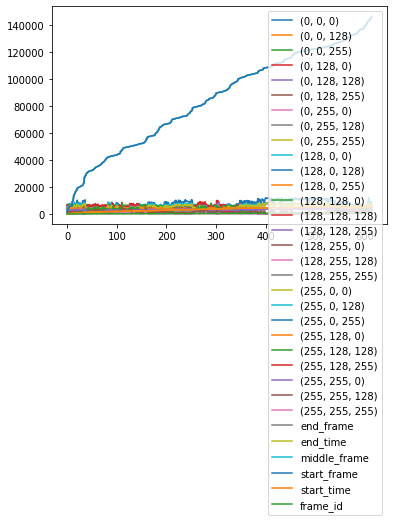

In [3]:
plt.close("all")
data_df.plot()
plt.show()

<AxesSubplot:>

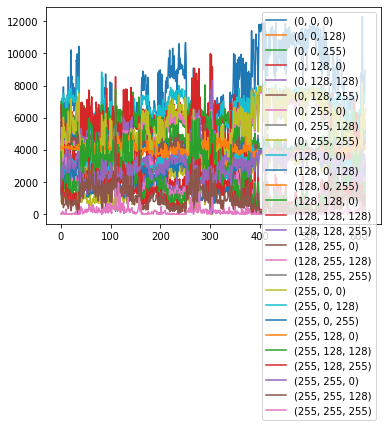

In [4]:
colors_df = data_df[["(0, 0, 0)","(0, 0, 128)","(0, 0, 255)","(0, 128, 0)","(0, 128, 128)","(0, 128, 255)","(0, 255, 0)","(0, 255, 128)","(0, 255, 255)","(128, 0, 0)","(128, 0, 128)","(128, 0, 255)","(128, 128, 0)","(128, 128, 128)","(128, 128, 255)","(128, 255, 0)","(128, 255, 128)","(128, 255, 255)","(255, 0, 0)","(255, 0, 128)","(255, 0, 255)","(255, 128, 0)","(255, 128, 128)","(255, 128, 255)","(255, 255, 0)","(255, 255, 128)","(255, 255, 255)"]]
colors_df.plot()

In [5]:
#numerical_df = data_df.drop(columns=["end_frame","end_time","img_path","length","middle_frame","start_frame","start_time","filename","object_labels"])
numerical_df = colors_df
print(numerical_df)

       (0, 0, 0)  (0, 0, 128)  (0, 0, 255)  (0, 128, 0)  (0, 128, 128)  \
0    3867.343895  3637.546540  2037.422507  4896.568180    4666.770825   
1    5210.163760  3581.850218  2624.749928  4954.966738    3326.653196   
2    7048.486982  4695.823260  4081.579478  5771.219120    3418.555397   
3    5866.305614  4145.388458  3291.526567  5362.353202    3641.436045   
4    3983.606436  2993.471874  1869.832447  4616.345162    3626.210600   
..           ...          ...          ...          ...            ...   
609  7166.222640  5071.739605  4261.976115  5878.282544    3783.799509   
610  8634.020868  5892.046481  5365.549908  6370.500855    3628.526468   
611  6900.204893  4755.424860  3999.398438  5716.608748    3571.828714   
612  8771.024418  5871.250201  5407.775337  6366.466411    3466.692194   
613  8964.062937  5718.871445  5468.774780  6453.005235    3207.813743   

     (0, 128, 255)  (0, 255, 0)  (0, 255, 128)  (0, 255, 255)  (128, 0, 0)  \
0      3066.646792  2628.763393  

<AxesSubplot:>

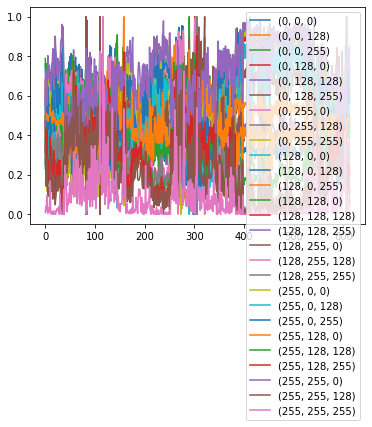

In [6]:
x = numerical_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
scaled_df = pd.DataFrame(x_scaled, columns=numerical_df.columns)
scaled_df.plot()

In [7]:
column_indices = {name: i for i, name in enumerate(scaled_df.columns)}

n = len(scaled_df)
train_df = scaled_df[0:int(n*0.7)]
test_df = scaled_df[int(n*0.7):]

num_features = scaled_df.shape[1]

In [8]:
def create_dataset(X, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i: (i + time_steps)].to_numpy()
        Xs.append(v)
        ys.append(X.iloc[i + time_steps].to_numpy())
    return np.array(Xs), np.array(ys)

In [9]:
TIME_STEPS = 10

X_train, y_train = create_dataset(train_df, time_steps=TIME_STEPS)
X_test, y_test = create_dataset(test_df, time_steps=TIME_STEPS)

In [10]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(419, 10, 27) (419, 27)
(175, 10, 27) (175, 27)


In [11]:
model = tf.keras.Sequential()
model.add(
    layers.Bidirectional(
        layers.LSTM(
            units=128,
            input_shape=(X_train[1], X_train[2])
        )
    )
)
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=y_train.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')

In [12]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    shuffle=False
)

Epoch 1/30
11/11 [==============================] - 30s 492ms/step - loss: 0.1500 - val_loss: 0.0543
Epoch 2/30
11/11 [==============================] - 0s 20ms/step - loss: 0.0416 - val_loss: 0.0513
Epoch 3/30
11/11 [==============================] - 0s 20ms/step - loss: 0.0285 - val_loss: 0.0343
Epoch 4/30
11/11 [==============================] - 0s 19ms/step - loss: 0.0232 - val_loss: 0.0248
Epoch 5/30
11/11 [==============================] - 0s 21ms/step - loss: 0.0228 - val_loss: 0.0218
Epoch 6/30
11/11 [==============================] - 0s 20ms/step - loss: 0.0207 - val_loss: 0.0214
Epoch 7/30
11/11 [==============================] - 0s 22ms/step - loss: 0.0201 - val_loss: 0.0207
Epoch 8/30
11/11 [==============================] - 0s 21ms/step - loss: 0.0196 - val_loss: 0.0195
Epoch 9/30
11/11 [==============================] - 0s 19ms/step - loss: 0.0194 - val_loss: 0.0190
Epoch 10/30
11/11 [==============================] - 0s 23ms/step - loss: 0.0189 - val_loss: 0.0184
Epoch 1

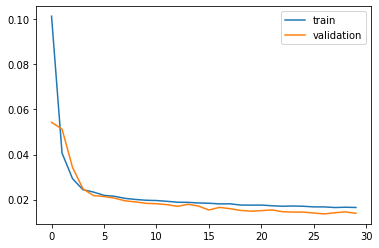

In [13]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()

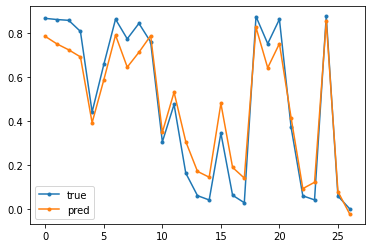

In [14]:
y_pred = model.predict(X_test)
plt.plot(y_test[0], marker='.',label='true')
plt.plot(y_pred[0], marker='.',label='pred')
plt.legend()

<AxesSubplot:>

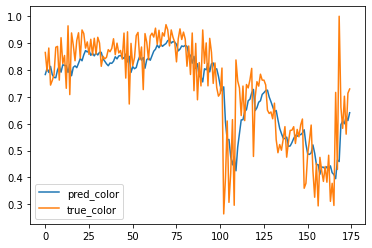

In [15]:
pred_difference = y_test - y_pred
pred_df = pd.DataFrame()
for i in range(len(y_test)):
    sample = {'true_color': y_test[i][0],
             'pred_color': y_pred[i][0]}
    pred_df = pred_df.append(sample, ignore_index=True)
pred_df.plot()

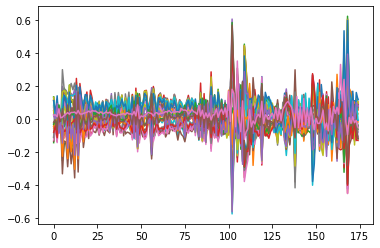

In [16]:
plt.plot(pred_difference)